# main.py

In [1]:
'''
File : Main notebook
Author : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois
Date : 06 déc 2023
Robot control and management of vision, global navigation, local navigation and Kalman filter.
'''

'\nFile : Main notebook\nAuthor : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois\nDate : 06 déc 2023\nRobot control and management of vision, global navigation, local navigation and Kalman filter.\n'

TO DO:

- commentaires tous en anglais
- virer les prints inutiles

### Initialisations

In [2]:
# Import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math

# Import project files
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf

In [3]:
# Connect to Thymio
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 328bdb70-11b8-49f9-b631-ac6519113084

In [4]:
SPEED_STOP = 0
SPEED_FORWARD = 50
SPEED_TURN = 30
SPEED_BACKWARD = 50

PROX_1_THRESHOLD = 4000
PROX_2_THRESHOLD = 2000
PROX_3_THRESHOLD = 1000
THRESHOLD_PROX_SENSOR = 20

SPEED_CORRECTION = 1 

ROTATION_STATE = 1
TRANSLATION_STATE = 2
CAMERA_STATE = 3
LOCAL_AVOIDANCE_STATE = 4

# Convertion ratios
PIXEL_TO_CM_RATIO = 0.05406       
CM_TO_PIXEL_RATIO = 18.4971

In [5]:
# Set the motor speeds
async def stop_robot():
    '''
    @brief   Stop the robot. Set the motor speed of each wheel to zero.
    '''
    await node.set_variables({
            "motor.right.target": [SPEED_STOP],
            "motor.left.target": [SPEED_STOP],
        })

    
async def move_robot(right_speed, left_speed):
    '''
    @brief   Turn the robot wheels to the given speeds.

    @param   right_speed -> right wheel speed in [thymio speed]
             left_speed  -> left wheel speed in [thymio speed]
    '''
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [6]:
# Get the proximity sensor values
async def get_prox_sensors():
    '''
    @brief   Get the sensor measurements of a the proximity sensors.

    @return  prox_sensors  -> numpy array of fron proximity sensors measurements
             detected      -> boolean = True if any sensors measured a higher value than threshold
    '''
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([PROX_1_THRESHOLD, PROX_2_THRESHOLD, PROX_3_THRESHOLD, 
                                                   PROX_2_THRESHOLD, PROX_1_THRESHOLD])) 
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected



# Get the motor speed measurement values
async def get_motor_speed_meas():
    '''
    @brief   Get the motor speed measurements.

    @return  speed_left_meas    -> left wheel speed in [thymio speed]
             speed_right_meas   -> right wheel speed in [thymio speed]
    '''
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

### Step 1: Check the connexion between the Thymio and the computer

In [7]:
await move_robot(SPEED_FORWARD, SPEED_FORWARD)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

### Step 2: Detect the map with vision and global path planning

Coordonnées obstacles noirs : [[(549, 1080), (868, 1080), (868, 604), (549, 604)], [(1063, 1080), (1369, 1080), (1369, 614), (1063, 614)], [(0, 1080), (303, 1080), (303, 498), (0, 498)]]
Centroid de la goal area : [1631.   571.5]
Vecteur direction du robot : 95 1
Centroid du robot : [354 556]


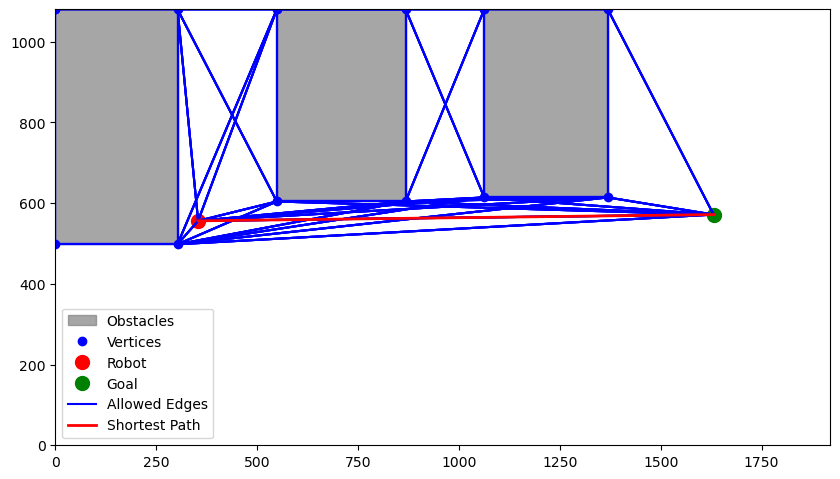

In [8]:
# Get the coordinates of the obstacles and the goal coordinates
obstacles, goal_centroid = vision.vision_obstacles_and_goal()
robot_centroid, robot_direction = vision.vision_robot()

# Get the robot initial position and its direction
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot()

# Compute the shortest path with the global navigation
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))

# Convert the cordinates of the goals and the robot position in centimeter
shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)

1 1
Kalman:  19.000000000000096 30.0 0.010525927031793158 0.22000022000022 0.13750013750013748
[0.01052593] [0.] [-0.01052593]
2 2
Kalman:  19.004521721401087 30.000051337865308 0.0111626762775515 0.08800000336376643 0.05500000210213331
translation: [(88, 30)]
Error: [68.99547828]
3 2
Kalman:  19.31579887189052 30.003455758358776 0.011468810018848299 1.3538483238469265 1.3750022396699233
translation: [(88, 30)]
Error: [68.68420122]
4 2
Kalman:  20.102600381609818 30.012225017131534 0.012129487934501349 2.38603279808672 2.326179761594058
translation: [(88, 30)]
Error: [67.89740072]
5 2
Kalman:  21.098036539952265 30.024535248565535 0.013247974130628925 2.5429805575866773 2.5201153772344393
translation: [(88, 30)]
Error: [66.90196796]
6 2
Kalman:  22.11680792792898 30.041015817675376 0.00822433534456268 2.365002432542592 2.6621917878856207
translation: [(88, 30)]
Error: [65.88320484]
7 2
Kalman:  23.16497371339081 30.04883655096037 0.0009760796669496523 2.534961690105453 2.75045373745000

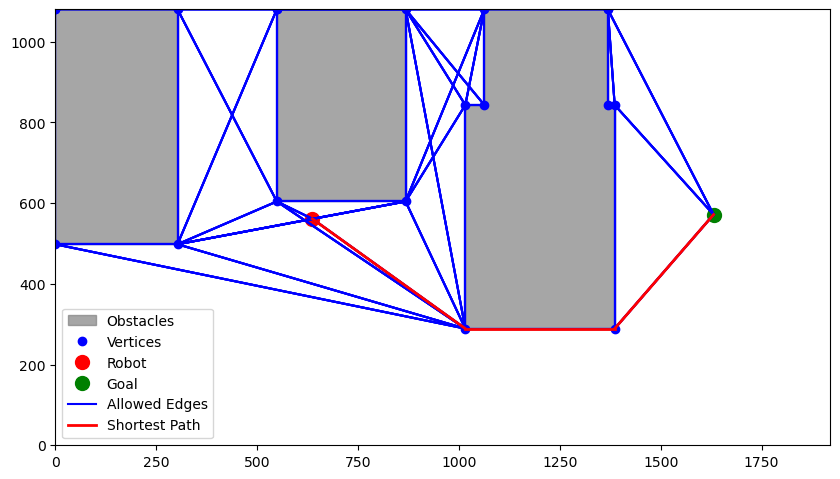

glob nav path : [(637.0, 561.0), (1016.0, 289.0), (1386.0, 289.0), (1631.0, 571.5)]
camera measurements:  (34, 30) -0.16697016902492895
centroid camera:  (34, 30)
camera fin: [(54, 15), (74, 15), (88, 30)]
36 1
Kalman:  33.99999979675716 30.000019310088444 -0.16644640244074954 -1.9062938286637816 -1.8362845005494546
[-0.1664464] [-0.64350172] [-0.47705532]
37 1
Kalman:  33.34072576795403 30.110714338137218 -0.178768450897123 -1.73951408586189 -0.7095850452851811
[-0.17876845] [-0.63150688] [-0.45273843]
38 1
Kalman:  32.998768222604156 30.17057122999734 -0.22705579059562714 -1.6486891385597209 0.5772851556010086
[-0.22705579] [-0.62557938] [-0.39852359]
39 1
Kalman:  32.86807989463272 30.201117012843806 -0.3018451617671292 -1.5814132117864488 1.2061680792918805
[-0.30184516] [-0.62359079] [-0.32174563]
40 1
Kalman:  32.81092349900474 30.219109618224422 -0.38858508162396366 -1.6577874944835782 1.4124811674162985
[-0.38858508] [-0.62287129] [-0.23428621]
41 1
Kalman:  32.778716899721864 

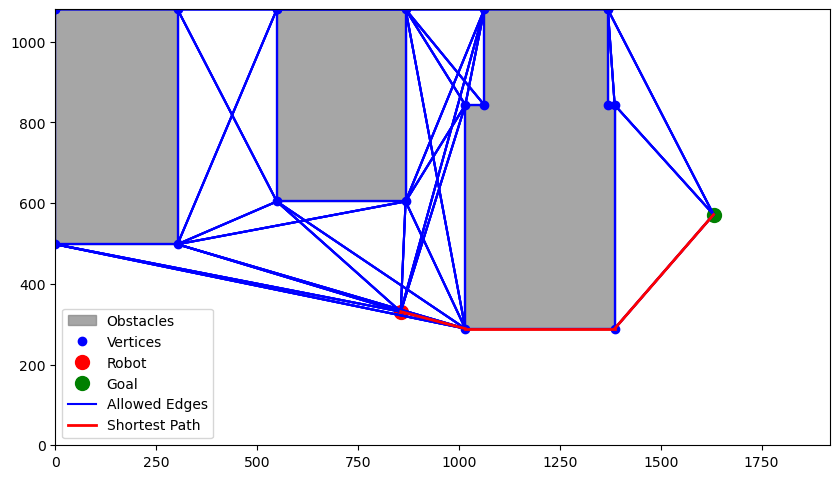

glob nav path : [(856.0, 331.0), (1016.0, 289.0), (1386.0, 289.0), (1631.0, 571.5)]
camera measurements:  (46, 17) -0.7531512809621944
centroid camera:  (46, 17)
camera fin: [(74, 15), (88, 30)]
70 1
Kalman:  46.00065756390749 16.999580086036243 -0.7520344352986333 1.032616475543425 1.304043233690726
[-0.75203444] [-0.07129421] [0.68074022]
71 1
Kalman:  46.27917720204783 16.738907950445096 -0.7450504824979148 1.0988646628568988 -0.08691407330041057
[-0.74505048] [-0.06264722] [0.68240326]
72 1
Kalman:  46.38874785884096 16.63663595307947 -0.6923432038808884 1.4378600586257868 -0.9483368688865059
[-0.6923432] [-0.05920497] [0.63313824]
73 1
Kalman:  46.44379614228663 16.59100580025433 -0.6128179333253598 1.6028500021111816 -1.3478184811921436
[-0.61281793] [-0.05767273] [0.55514521]
74 1
Kalman:  46.4672813286332 16.575370348607787 -0.523103175193684 1.5979963793067122 -1.5345672942457442
[-0.52310318] [-0.0571558] [0.46594738]
75 1
Kalman:  46.47782681350564 16.569296742778192 -0.4299

TypeError: cannot unpack non-iterable NoneType object

In [9]:
#ROBOT CONTROL AND LOCALISATION

# state variables
global_state = ROTATION_STATE

intermediate_goals = shortest_path
intermediate_goals.pop(0)

robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])
robot_speed = [0.0,0.0]

Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)


old_time = 0.0
printkal = True
iter = 0
while(True):
    iter = iter + 1
    print(iter, global_state)

    if intermediate_goals == []:
        await stop_robot()
        print("je suis au goal")
        break
    
    # get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    
    # test if local (with proximity)
    if(detected):
        await stop_robot()
        global_state = LOCAL_AVOIDANCE_STATE

    
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    speed_right_meas = speed_right_meas * SPEED_CORRECTION
    speed_left_meas = speed_left_meas * SPEED_CORRECTION

    Kfilter.measurement_wheels(speed_right_meas / 18.1818, speed_left_meas / 18.1818)

    if iter == 0:                   # first time
        old_time = time.time()
    dt = time.time() - old_time     # get time difference for Kalman
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()

    if printkal:
        print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])
    
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    if global_state == ROTATION_STATE:
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        print(Kfilter.Mu[2], np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), angle)
        
        if(abs(angle) < 0.1):
            await stop_robot()
            global_state = TRANSLATION_STATE
            continue

        if(angle > 0):
            robot_speed = [SPEED_TURN, -SPEED_TURN]         # counterclockwise
            speed_correction = SPEED_CORRECTION 
        else:
            robot_speed = [-SPEED_TURN, SPEED_TURN]         # clockwise
            speed_correction = SPEED_CORRECTION 

            
    elif global_state == TRANSLATION_STATE:
        
        print("translation:", intermediate_goals)
        print("Error:", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= 0.8:
            print("je m'arrete")
            await stop_robot()
            global_state = CAMERA_STATE
            continue
            
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        
        P_control_translation = 0 / (math.pi / 4.0)
        robot_speed = [50 + int(P_control_translation*angle), 50 - int(P_control_translation*angle)]
        speed_correction = 0.75

        
        if abs(angle) > math.pi / 2.0:
            await stop_robot()
            global_state = CAMERA_STATE
            continue
        
        
    elif global_state == CAMERA_STATE:
        robot_centroid = [0,0]
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            robot_centroid, robot_direction = vision.vision_robot()
            
        merge_need = True
        visualize = True
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))
        print("glob nav path :", shortest_path)
        
        
        shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
        robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO) #changer pixel
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        print("camera measurements: ", robot_centroid, robot_angle)
        printkal = True
        
        intermediate_goals = shortest_path
        intermediate_goals.pop(0)
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= 0.8:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("camera fin:", shortest_path)
        
        global_state = ROTATION_STATE
        continue
        
        
        
    elif global_state == LOCAL_AVOIDANCE_STATE:
        print("local")
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        
        if ln.is_inside(object_ground_coords, obstacles):
            continue

        Object = ln.safety_zone(object_ground_coords)
        Object = vision.converter(Object, CM_TO_PIXEL_RATIO)
    
        obstacles.append(Object)
        prox_sensors_bool = True
        
        while prox_sensors_bool:
            await move_robot(-SPEED_BACKWARD, -SPEED_BACKWARD)
            await client.sleep(2)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * THRESHOLD_PROX_SENSOR) 
            await client.sleep(0.4)
        
        global_state = CAMERA_STATE
        continue

        
        
    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)


    

In [13]:
await stop_robot()